In [1]:
%cd ..

/home/jairo/Documentos/GitHub/parallel-kink-scattering


/home/jairo/Documentos/GitHub/parallel-kink-scattering/.env/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from modules.numeric import *
from modules.plotting import *
cmap = get_cmap()

In [3]:
L = 40
N = 1000 #int(L/40*1000)
DX = L/(N - 1)
DT = 0.7*DX
LAMB = 2
X0 = 10 #15*delta(lamb)/2 #L/3

In [4]:
def plot_boundary_scatter(v, H):
    COLLIDER = KinkCollider(0, -L, N, (-X0, X0), DT, DX, order=4, H=H) 
    field = kink_boundary(-X0, v, LAMB, H=H)
    phi = lambda x: field(x, 0)
    phi_dt = lambda x: field.diff(1)(x, 0)
    y0 = np.stack((
        phi(COLLIDER.x), 
        phi_dt(COLLIDER.x)
    ))
    t_final = L/v
    t, Y = rk4_solve(COLLIDER.get_system(lamb=LAMB), y0, DT, t_final)
    y = Y[:, 0]
    plt.imshow(y.T, cmap=cmap, vmin=-2, vmax=2, aspect='auto', extent=(t.min(), t.max(), COLLIDER.x.min(), COLLIDER.x.max()))
    plt.xlim(0, 100)
    plt.ylim(-25, 0)
    plt.show()

In [5]:
H = -0.2
(1 - 4*( (1 + H)**(3/2) + (1 - H)**(3/2) )**-2)**0.5

0.17149583947356087

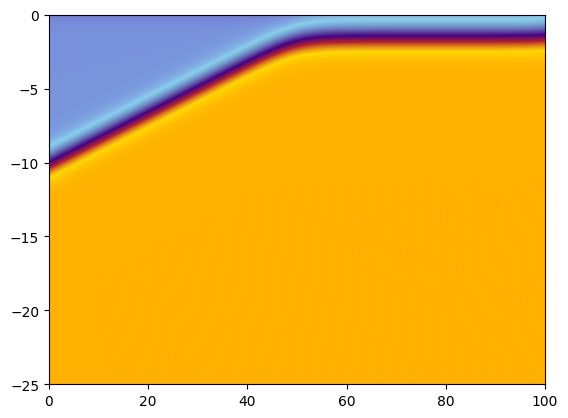

In [6]:
plot_boundary_scatter(v=0.1714956, H=-0.2)

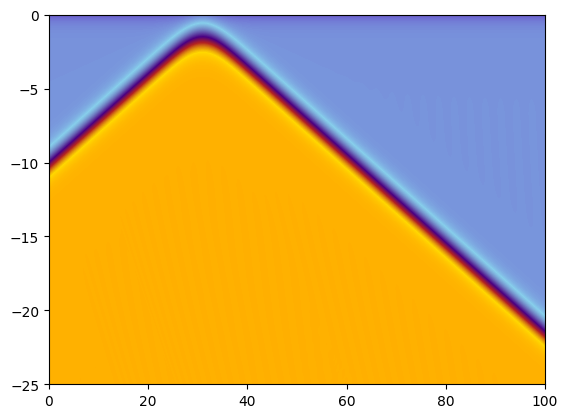

In [7]:
plot_boundary_scatter(v=0.3, H=-0.5)

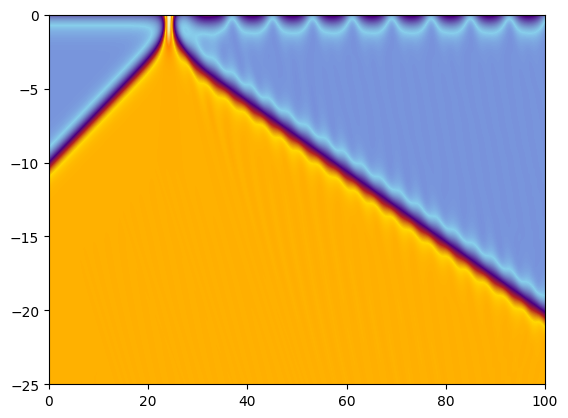

In [8]:
plot_boundary_scatter(v=0.35, H=0.9)

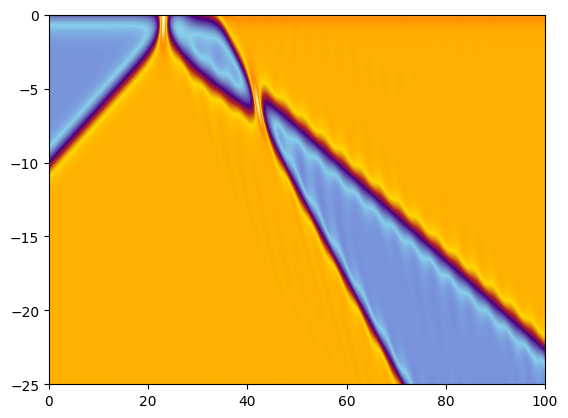

In [9]:
plot_boundary_scatter(v=0.37, H=0.9)

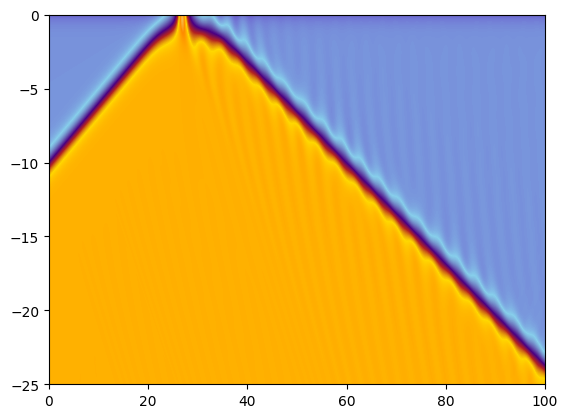

In [10]:
plot_boundary_scatter(v=0.4, H=-0.4)

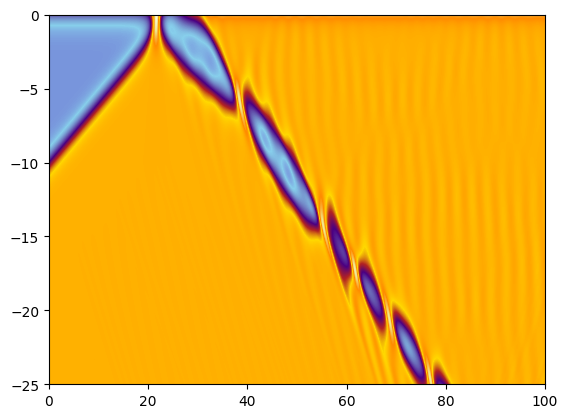

In [11]:
plot_boundary_scatter(v=0.4, H=0.9)